# Galaxy Morph
This textbook illustrates how the extension of lenstronomy can simulate spirals and do simple fittings.

In [36]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [37]:
# data specifics / simulation config
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 50  #  cutout pixel size per axis
deltaPix = 0.5  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width at half maximum of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

## First exmaple: bending mode
In this example we try to utilize a simople distrortion for the desacription of the sprial arms. The model only have one parameter for the shape of the pattern, so the convergence can be easily reached.

In [71]:
# These are new types of "lenses" for the description of spiral arms from GALFIT.
kwargs_Bending = {'Strength':  0.03, 'phi':0.3, 'center_x': 0, 'center_y': 0}

# Select Bending mode for image generation
lens_model_list = ['Bending3']
kwargs_lens = [kwargs_Bending]

# galaxymorph enables complicated shape formation
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list, galaxy_morph = True)

# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 10, 'R_sersic': 1, 'n_sersic': 4, 'e1': 0.4, 'e2': 0, 'center_x': 0, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)


kwargs_sersic_lens = {'amp': 5, 'R_sersic': 2, 'n_sersic': 1, 'e1': 0, 'e2': -0.3, 'center_x': 0, 'center_y': 0}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)


In [72]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

<ipython-input-73-fdef34d73218>:15: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


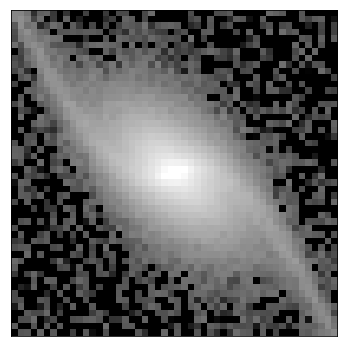

In [73]:
# display the initial simulated image
# Not that "real"

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [82]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
kwargs_lens_init.append({'phi':1, 'Strength':  0., 'center_x': 0, 'center_y': 0})
kwargs_lens_sigma.append({'phi':1, 'Strength':  0.1, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'phi':0, 'Strength':  -1, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'phi':2*np.pi, 'Strength':  1, 'center_x': 10, 'center_y': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({})
kwargs_source_init.append({'amp': 1, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_source_sigma.append({'amp': 1, 'n_sersic': 1, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'amp': 0, 'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []#kwargs_lens_light
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({})
kwargs_lens_light_init.append({'amp': 1, 'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
kwargs_lens_light_sigma.append({'amp': 1, 'n_sersic': 1, 'R_sersic': 1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'amp': 0,  'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,}

# Summary of init & real condition
print('kwargs_lens_light_init\n',kwargs_lens_light_init,)
print('kwargs_lens_light\n',kwargs_lens_light,)
print('kwargs_source_init\n',kwargs_source_init,)
print('kwargs_source\n',kwargs_source)
print('kwargs_lens_init\n',kwargs_lens_init)
print('kwargs_lens\n',kwargs_lens)

kwargs_lens_light_init
 [{'amp': 1, 'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}]
kwargs_lens_light
 [{'amp': 5, 'R_sersic': 2, 'n_sersic': 1, 'e1': 0, 'e2': -0.3, 'center_x': 0, 'center_y': 0}]
kwargs_source_init
 [{'amp': 1, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0.0, 'center_y': 0}]
kwargs_source
 [{'amp': 10, 'R_sersic': 1, 'n_sersic': 4, 'e1': 0.4, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_init
 [{'phi': 1, 'Strength': 0.0, 'center_x': 0, 'center_y': 0}]
kwargs_lens
 [{'Strength': 0.03, 'phi': 0.3, 'center_x': 0, 'center_y': 0}]


In [83]:
# Start fitting
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list, 'galaxy_morph': True}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [  
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                        ['SIMPLEX', {'n_iterations': 1000}], # add this for higher probability for convergence
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                        ['SIMPLEX', {'n_iterations': 1000}], # add this for higher probability for convergence
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                        ['SIMPLEX', {'n_iterations': 1000}], # add this for higher probability for convergence
                       #['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

{'lens_model_list': ['Bending3'], 'source_light_model_list': ['SERSIC_ELLIPSE'], 'lens_light_model_list': ['SERSIC_ELLIPSE'], 'galaxy_morph': True}
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.961051101571328 reduced X^2 of best position
-1192.664417050018 logL
2482 effective number of data points
[{'Strength': 0.030241442075569464, 'center_x': 0.004140346788197857, 'center_y': -0.005379434796506488, 'phi': 3.443768511482146}] lens result
[{'amp': 1, 'R_sersic': 0.9877416135896834, 'n_sersic': 4.199432302758703, 'e1': 0.4016140188141054, 'e2': -0.0043268871584832185, 'center_x': 0.004689841974562652, 'center_y': -0.010562732441271898}] source result
[{'amp': 1, 'R_sersic': 2.007317037329415, 'n_sersic': 1.0302918120099074, 'e1': 0.003583553140048307, 'e2': -0.3013841517305683, 'center_x': -0.008612236843860395, 'center_y': 0.0023083220663733172}] lens light result
[] point source result
{} special param

-0.9541309272622746 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9541309272622748


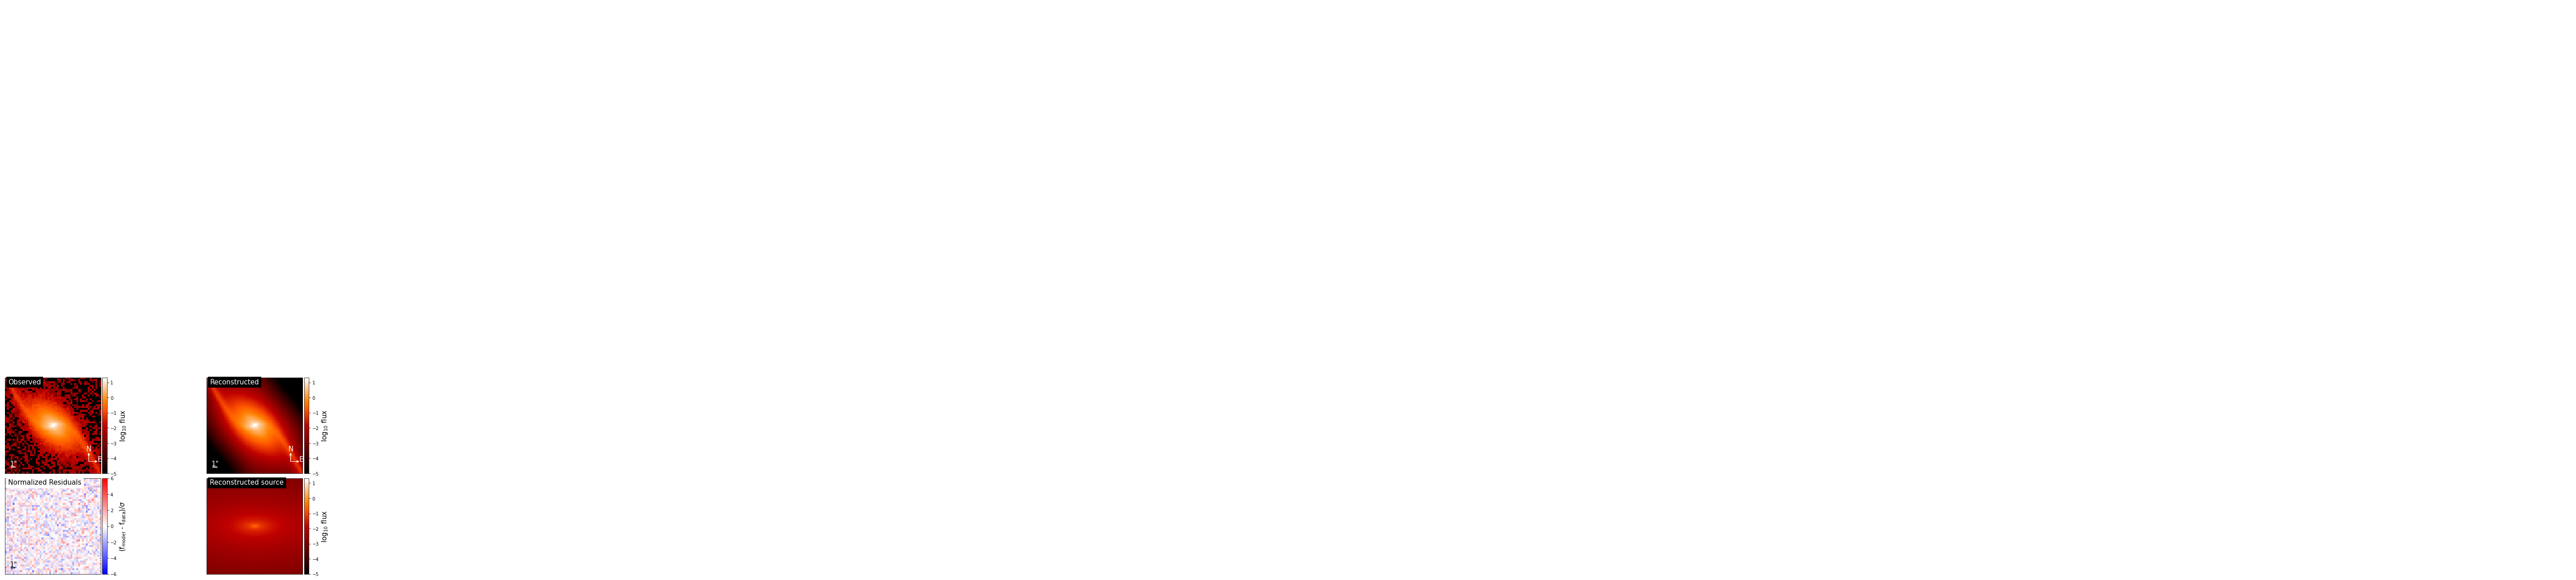

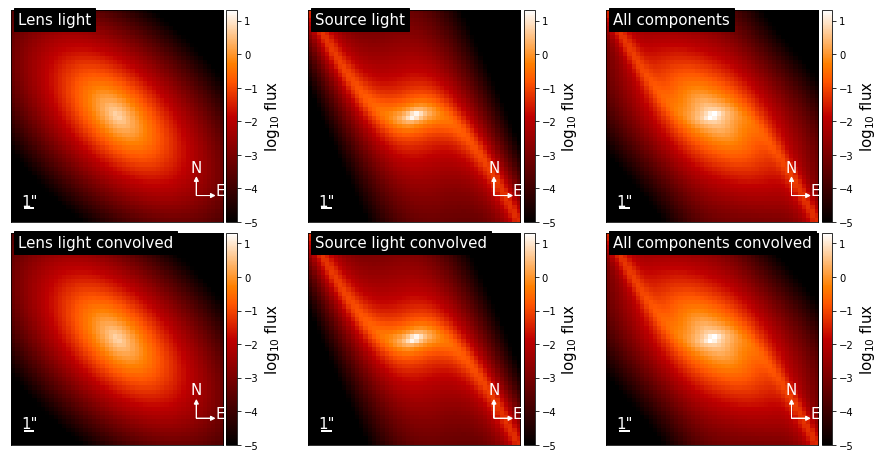

{'kwargs_lens': [{'Strength': 0.030248207561620312, 'center_x': 0.004003807630678098, 'center_y': -0.005371344697923835, 'phi': 3.4438168771594793}], 'kwargs_source': [{'amp': 10.060816614064228, 'R_sersic': 0.9874266821703408, 'n_sersic': 4.200267389983313, 'e1': 0.4016131539795541, 'e2': -0.0043604406858024115, 'center_x': 0.004430954865574348, 'center_y': -0.010519617586696917}], 'kwargs_lens_light': [{'amp': 4.923156149176492, 'R_sersic': 2.0074727100844463, 'n_sersic': 1.030222473465097, 'e1': 0.0035751768993064455, 'e2': -0.30134210956299234, 'center_x': -0.008638587753095952, 'center_y': 0.002297382445000577}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [84]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[1,0], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 1], deltaPix_source=0.01, numPix=100)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  15
parameters in order:  ['Strength_lens0', 'center_x_lens0', 'center_y_lens0', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  90000
90000


<ipython-input-42-df4a5a2129e3>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


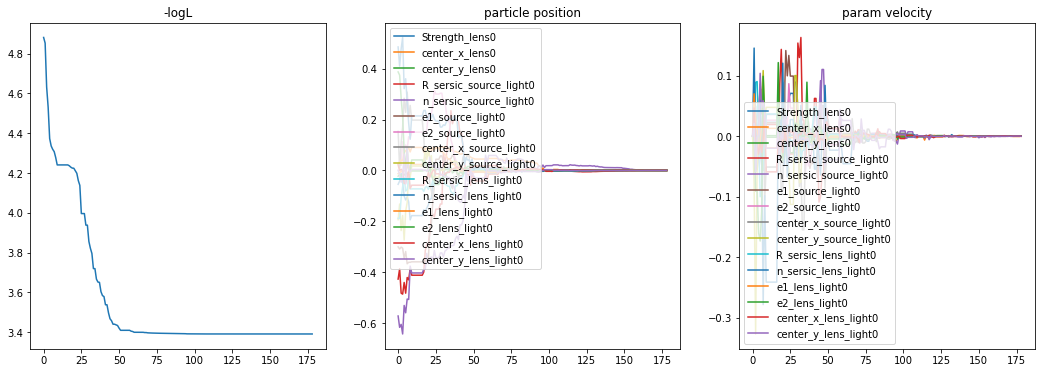

<Figure size 432x288 with 0 Axes>

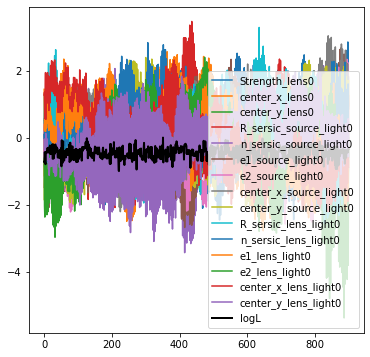

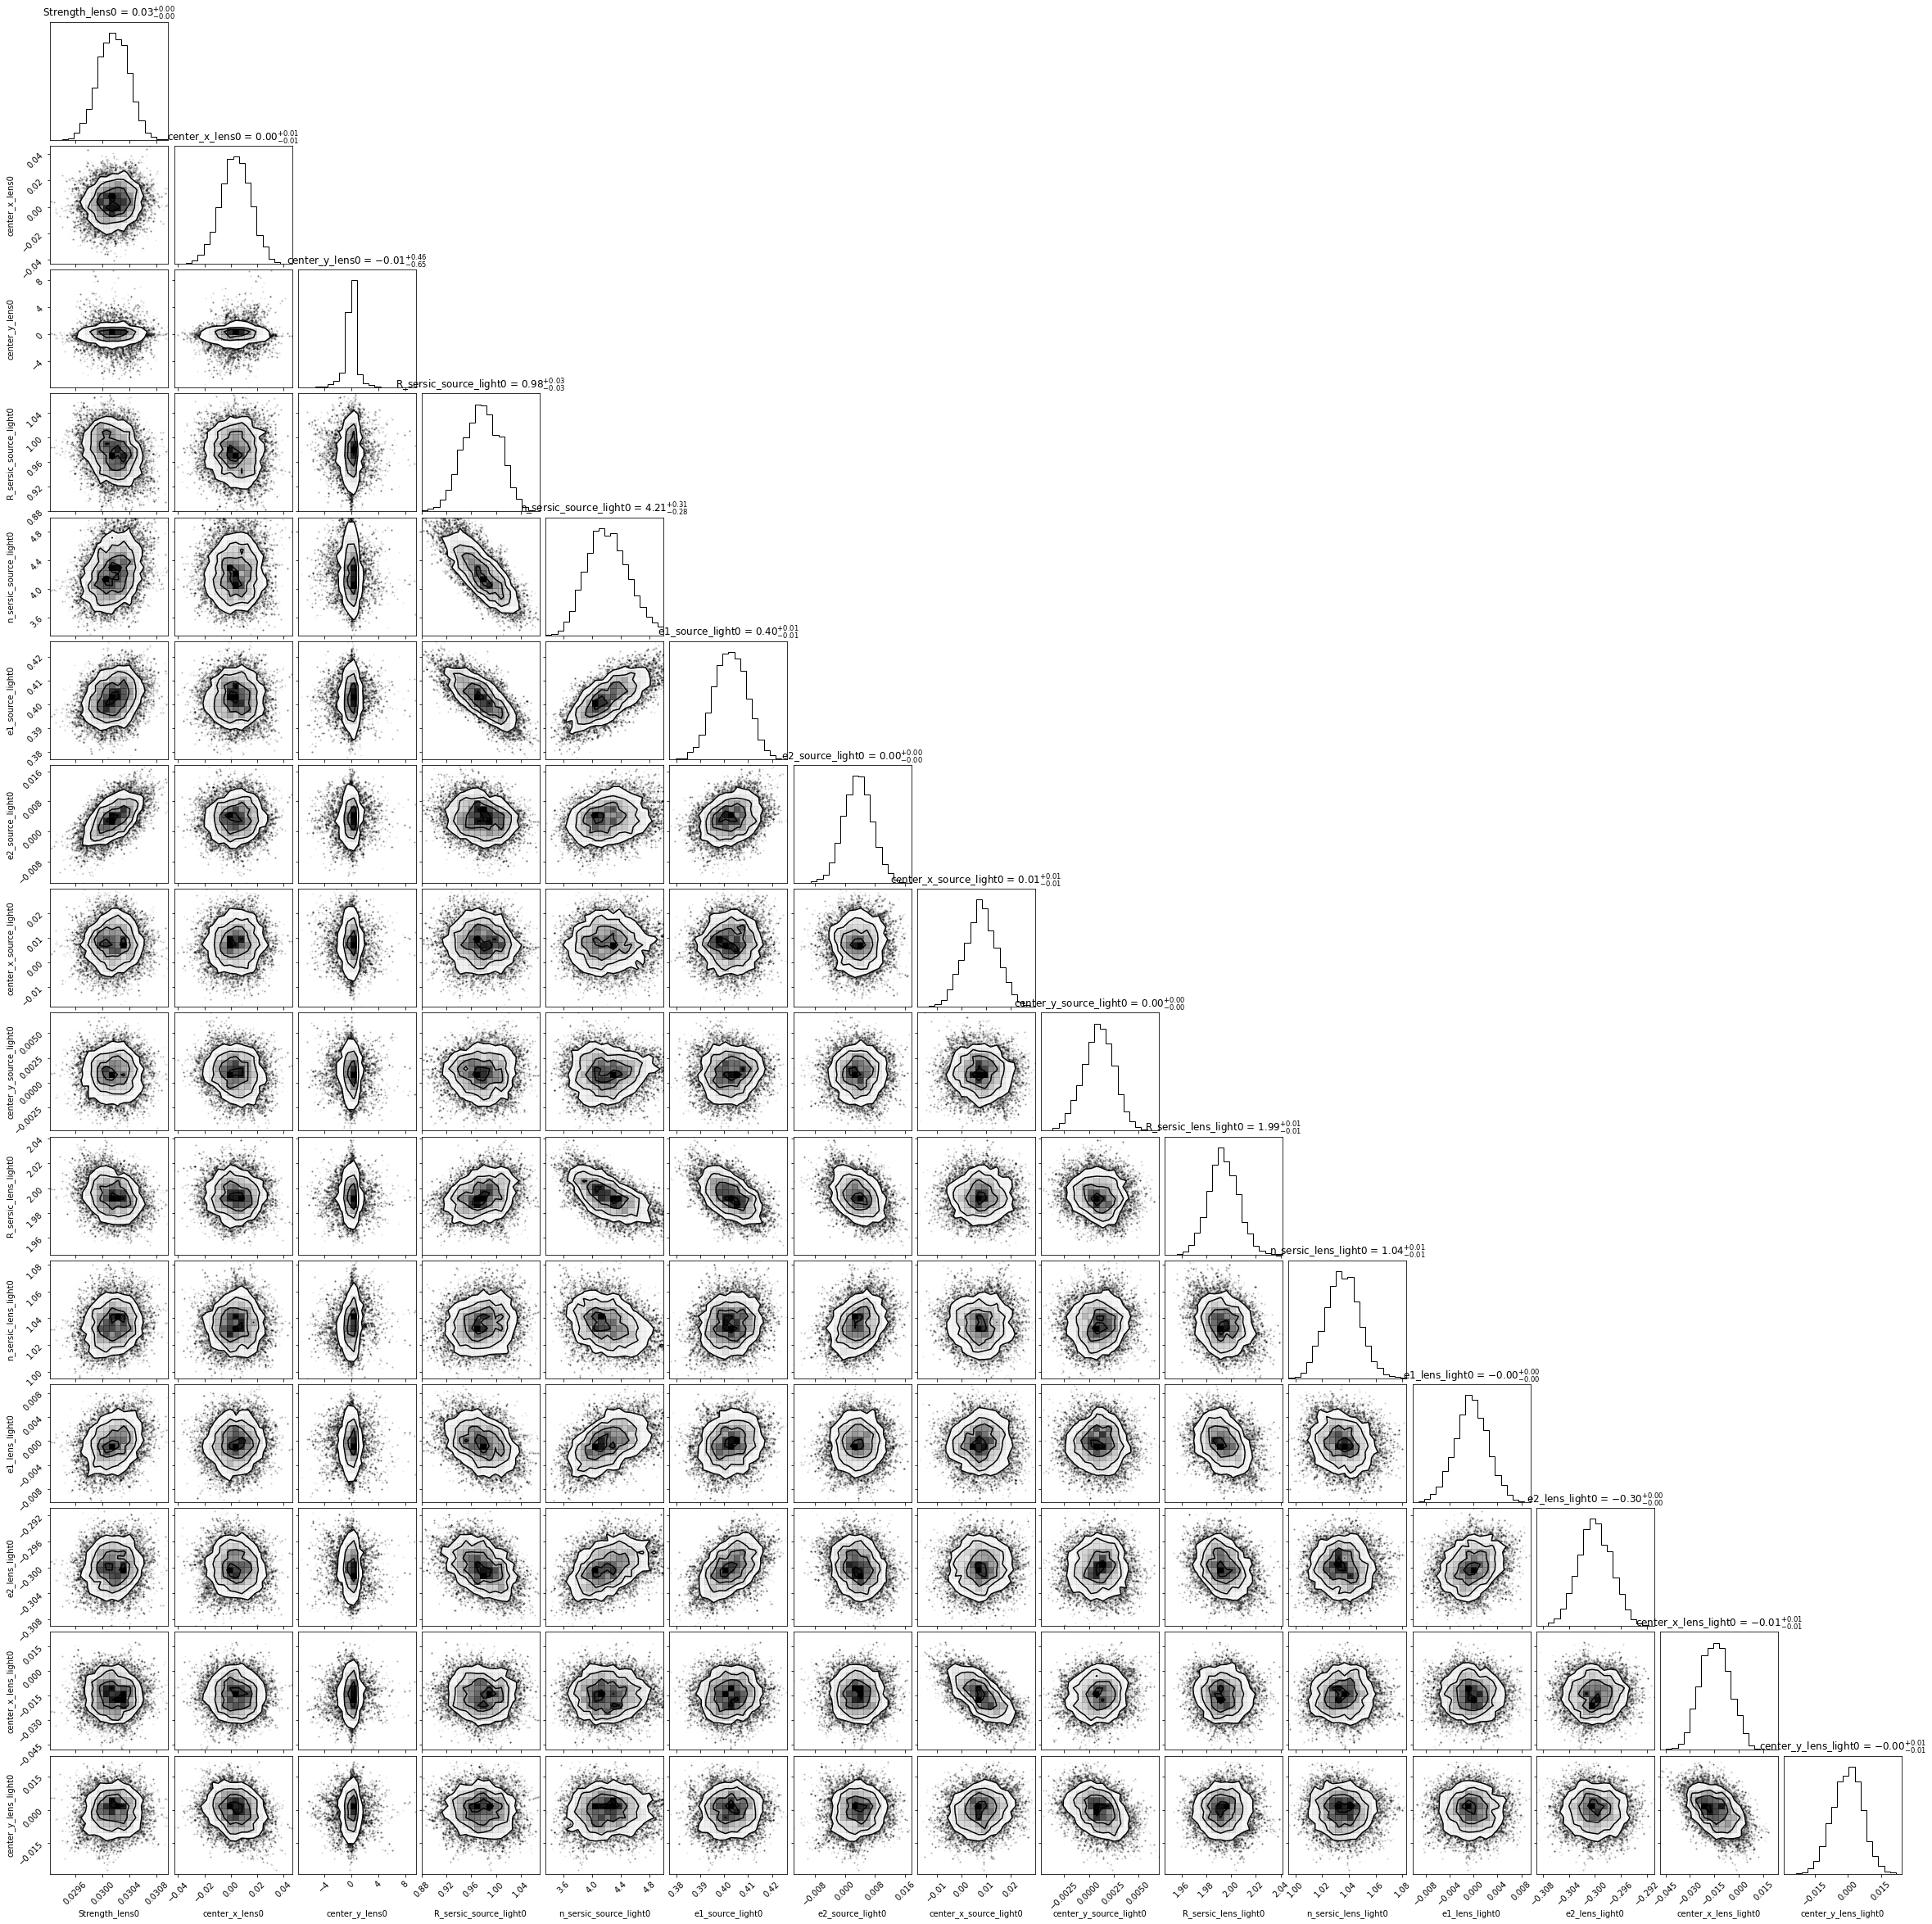

In [42]:
# the results of the MCMC chain

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)


## Toward a more complex model

Here we try to create a set of more realistic sprial arms with the combination of Fourier mode and power-law Hyperbolic Tangent coordinate rotationi. As the model is getting more complex, we will apply simplex solver ahead of PSO and MCMC. In the GALFIT implementation, the program reach a minimal residual with LM downhill method (similar to simplex).

In [43]:
# Fourier modes + Power-law pitch

kwargs_Fourier = {'m_1':0, 'm_3':0.0, 'm_4':0.3, 'm_5':-0.1, 'm_6':0, 'phi_1':0, 'phi_3':0.3, 'phi_4':0, 'phi_5':0.1, 'phi_6':0, 'center_x': 0, 'center_y': 0}  # parameters of the deflector lens model
kwargs_PHT = {'r_in':6, 'r_scale':9, 'theta_out':2, 'alpha':0.3, 'center_x': 0, 'center_y': 0}

lens_model_list = ['PHT', 'Fourier']
kwargs_lens = [kwargs_PHT, kwargs_Fourier]

from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list, galaxy_morph = True)

# Sersic parameters in the initial simulation for the source
kwargs_sersic = {'amp': 10, 'R_sersic': 1.5, 'n_sersic': 4, 'e1': 0.4, 'e2': 0, 'center_x': 0, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)


kwargs_sersic_lens = {'amp': 5, 'R_sersic': 2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}

lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(lens_light_model_list)


In [44]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

<ipython-input-45-fdef34d73218>:15: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


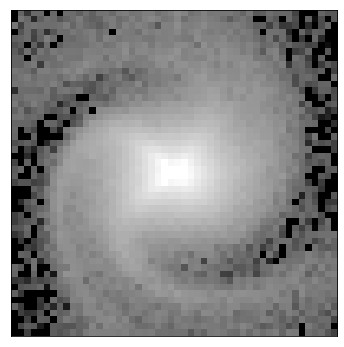

In [45]:
# display the initial simulated image
# Not that "real"

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [47]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# PHT
fixed_lens.append({'center_x': 0, 'center_y': 0})
kwargs_lens_init.append({'r_in':1, 'r_scale':1, 'theta_out': 0, 'alpha':0, 'phi_PA': 1})
kwargs_lens_sigma.append({'r_in':1, 'r_scale':1, 'theta_out': 3, 'alpha':1, 'phi_PA': 0.1})
kwargs_lower_lens.append({'r_in':0, 'r_scale':0, 'theta_out': -2*np.pi, 'alpha':-3, 'phi_PA': 0})
kwargs_upper_lens.append({'r_in':10, 'r_scale':10, 'theta_out': 2*np.pi, 'alpha':3, 'phi_PA': 2*np.pi})

# Fourier modes
fixed_lens.append({'m_1':0, 'm_3':0.0,  'phi_1':1, 'phi_3':1, 'center_x': 0, 'center_y': 0})
kwargs_lens_init.append({'m_4':0.0, 'm_5':0, 'm_6':0, 'phi_4':1, 'phi_5':1, 'phi_6':1, 'center_x': 0, 'center_y': 0})
kwargs_lens_sigma.append({'m_4':0.1, 'm_5':0.1, 'm_6':0.1, 'phi_4':0.1, 'phi_5':0.1, 'phi_6':0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'m_4':-1, 'm_5':-1, 'm_6':-1, 'phi_4':0, 'phi_5':0, 'phi_6':0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'m_4':1, 'm_5':1, 'm_6':1,'phi_4':np.pi, 'phi_5':np.pi, 'phi_6':np.pi, 'center_x': 10, 'center_y': 10})




lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []#kwargs_source
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({'center_x': 0., 'center_y': 0})
kwargs_source_init.append({'amp': 1, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, })
kwargs_source_sigma.append({'amp': 1, 'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
kwargs_lower_source.append({'amp': 0, 'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []#kwargs_lens_light
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({'center_x': 0., 'center_y': 0})
kwargs_lens_light_init.append({'amp': 1, 'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0,})
kwargs_lens_light_sigma.append({'amp': 1, 'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'amp': 0,  'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'amp': 100, 'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,}

# Summary of init & real condition
print('kwargs_lens_light_init\n',kwargs_lens_light_init,)
print('kwargs_lens_light\n',kwargs_lens_light,)
print('kwargs_source_init\n',kwargs_source_init,)
print('kwargs_source\n',kwargs_source)
print('kwargs_lens_init\n',kwargs_lens_init)
print('kwargs_lens\n',kwargs_lens)

kwargs_lens_light_init
 [{'amp': 1, 'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0}]
kwargs_lens_light
 [{'amp': 5, 'R_sersic': 2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_source_init
 [{'amp': 1, 'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0}]
kwargs_source
 [{'amp': 10, 'R_sersic': 1.5, 'n_sersic': 4, 'e1': 0.4, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_init
 [{'r_in': 1, 'r_scale': 1, 'theta_out': 0, 'alpha': 0, 'phi_PA': 1}, {'m_4': 0.0, 'm_5': 0, 'm_6': 0, 'phi_4': 1, 'phi_5': 1, 'phi_6': 1, 'center_x': 0, 'center_y': 0}]
kwargs_lens
 [{'r_in': 6, 'r_scale': 9, 'theta_out': 2, 'alpha': 0.3, 'center_x': 0, 'center_y': 0}, {'m_1': 0, 'm_3': 0.0, 'm_4': 0.3, 'm_5': -0.1, 'm_6': 0, 'phi_1': 0, 'phi_3': 0.3, 'phi_4': 0, 'phi_5': 0.1, 'phi_6': 0, 'center_x': 0, 'center_y': 0}]


In [54]:
# Start fitting
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list, 'galaxy_morph': True}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [ ['SIMPLEX', {'n_iterations': 100}], # add this for higher probability for convergence
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

{'lens_model_list': ['PHT', 'Fourier'], 'source_light_model_list': ['SERSIC_ELLIPSE'], 'lens_light_model_list': ['SERSIC_ELLIPSE'], 'galaxy_morph': True}
Performing the optimization using algorithm: Nelder-Mead
76.54264908927816 reduced X^2 of best position
-94912.88487070492 logL
2480 effective number of data points
[{'r_in': 1.0272483839046114, 'r_scale': 0.880714314190858, 'theta_out': 0.0011201789695741847, 'alpha': -0.0009740505267617884, 'center_x': 0, 'center_y': 0}, {'m_1': 0, 'm_3': 0.0, 'm_4': 0.000818212228932764, 'm_5': -0.0008394812506295525, 'm_6': -0.0009743553431972307, 'phi_1': 1, 'phi_3': 1, 'phi_4': 0.9180068603099905, 'phi_5': 0.9822976680990254, 'phi_6': 0.861618100777287, 'center_x': 0, 'center_y': 0}] lens result
[{'amp': 1, 'R_sersic': 0.09235225755569781, 'n_sersic': 0.9568877681707901, 'e1': -0.0002742351932880426, 'e2': -0.0016733081353183968, 'center_x': 0.0, 'center_y': 0}] source result
[{'amp': 1, 'R_sersic': 0.7101228229324021, 'n_sersic': 3.169688355378

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:34<00:00,  3.73it/s]

Computing the MCMC...
Number of walkers =  180
Burn-in iterations:  200
Sampling iterations (in current run): 800
214.9908139705658 time taken for MCMC sampling


-1.0180976218176467 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0180976218176458


c:\python38\lib\site-packages\lenstronomy\Plots\model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


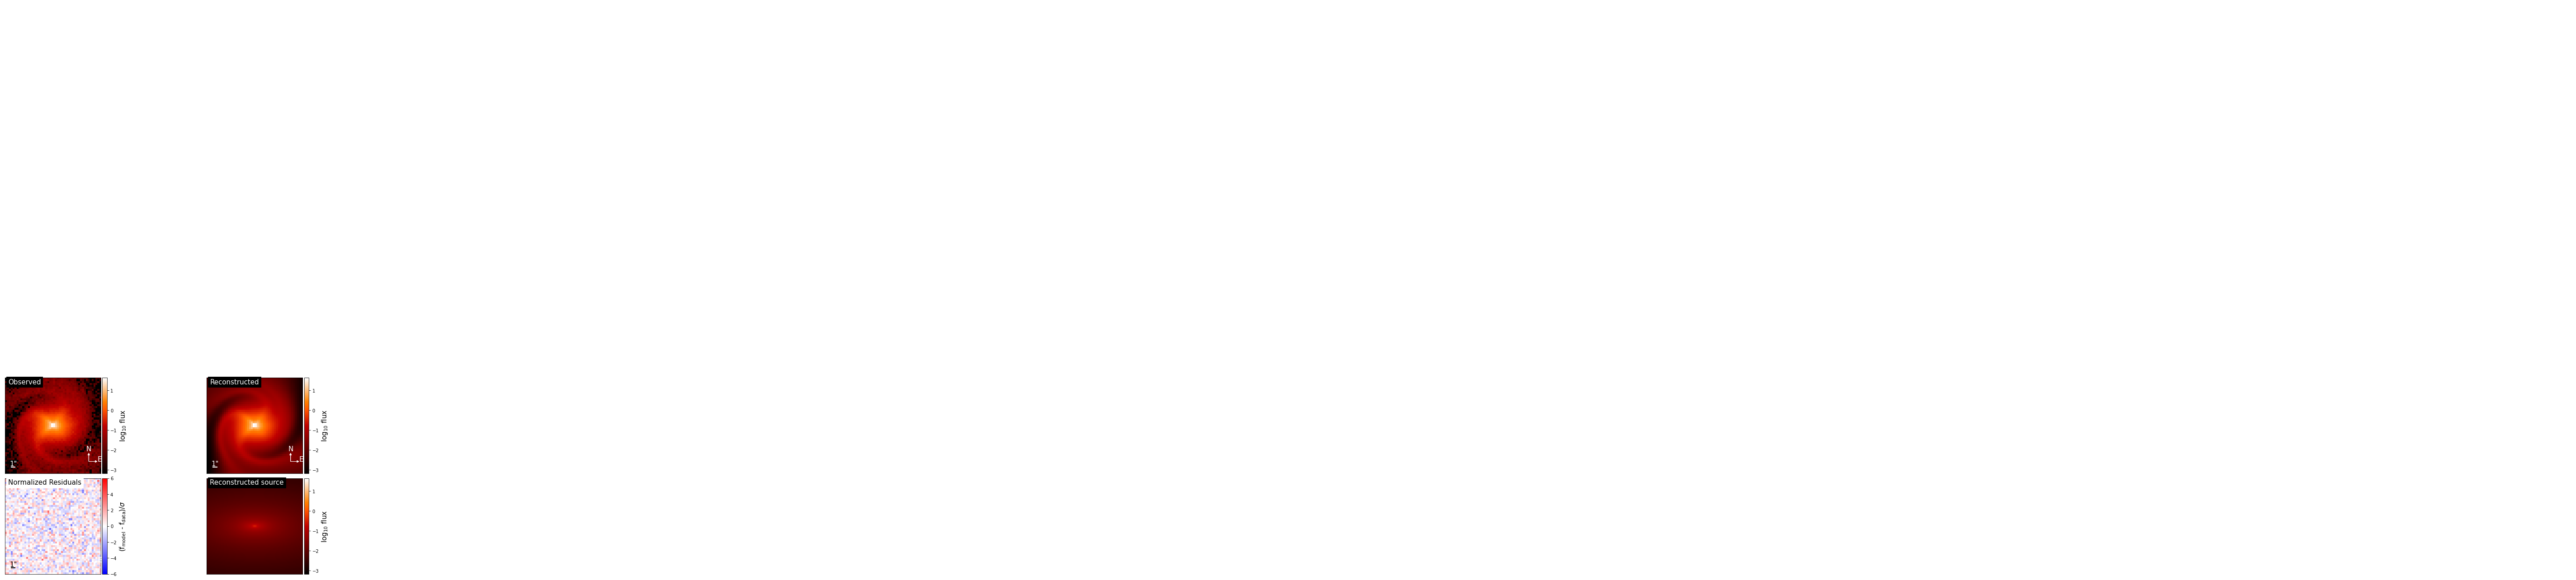

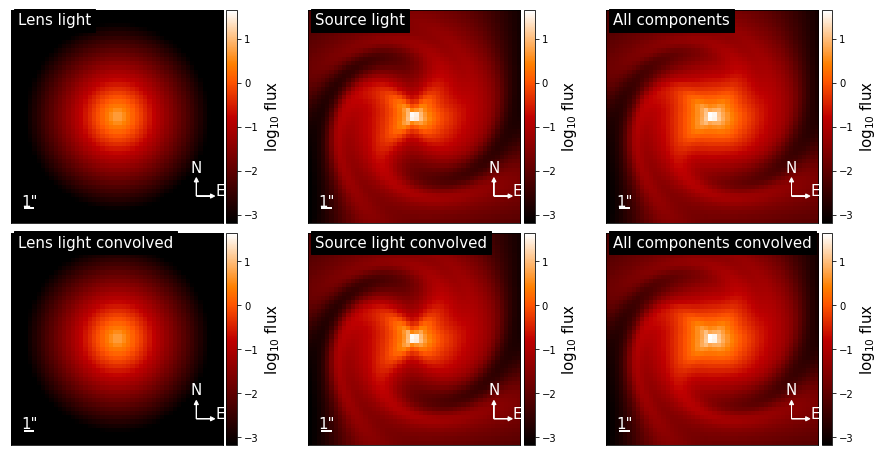

{'kwargs_lens': [{'r_in': 6.139848687542083, 'r_scale': 8.902830004979135, 'theta_out': 1.9916464540383614, 'alpha': 0.14363655887246135, 'center_x': 0, 'center_y': 0}, {'m_1': 0, 'm_3': 0.0, 'm_4': -0.29249364905863295, 'm_5': -0.10085163724146816, 'm_6': -0.0020512352944833854, 'phi_1': 1, 'phi_3': 1, 'phi_4': 0.7857628030229798, 'phi_5': 1.353615038004628, 'phi_6': 0.43457980563213183, 'center_x': 0, 'center_y': 0}], 'kwargs_source': [{'amp': 9.607224182963373, 'R_sersic': 1.5301840676914866, 'n_sersic': 4.066018207892601, 'e1': 0.39429501823127233, 'e2': -0.0018676991913661363, 'center_x': 0.0, 'center_y': 0}], 'kwargs_lens_light': [{'amp': 5.018959342289203, 'R_sersic': 1.977026559871132, 'n_sersic': 1.005624157887143, 'e1': -0.009542354298079554, 'e2': -0.0005945307871214251, 'center_x': 0.0, 'center_y': 0}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [55]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[1,0], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 1], deltaPix_source=0.01, numPix=100)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  18
parameters in order:  ['r_in_lens0', 'r_scale_lens0', 'theta_out_lens0', 'alpha_lens0', 'm_4_lens1', 'm_5_lens1', 'm_6_lens1', 'phi_4_lens1', 'phi_5_lens1', 'phi_6_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0']
number of evaluations in the MCMC process:  108000
108000


<ipython-input-62-34e29b5397b4>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


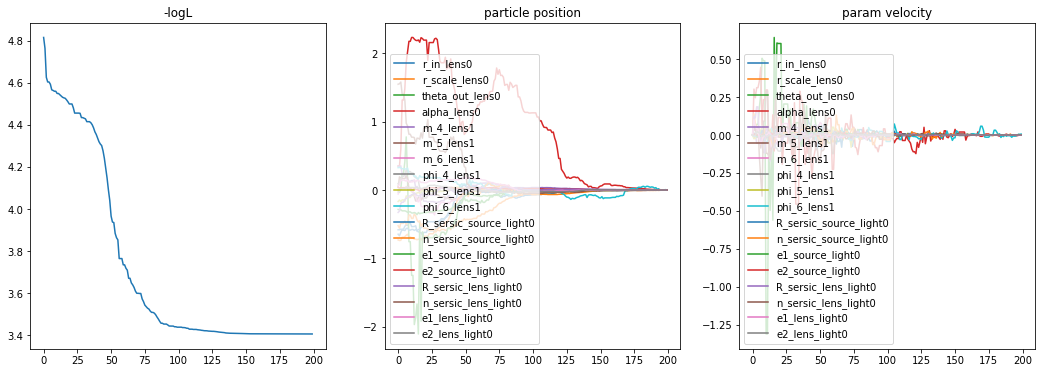

<Figure size 432x288 with 0 Axes>

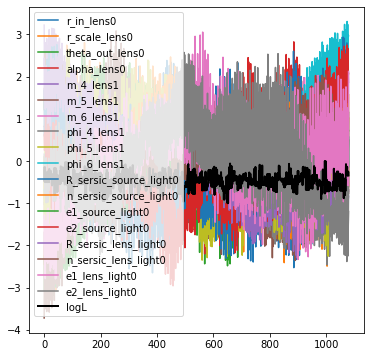

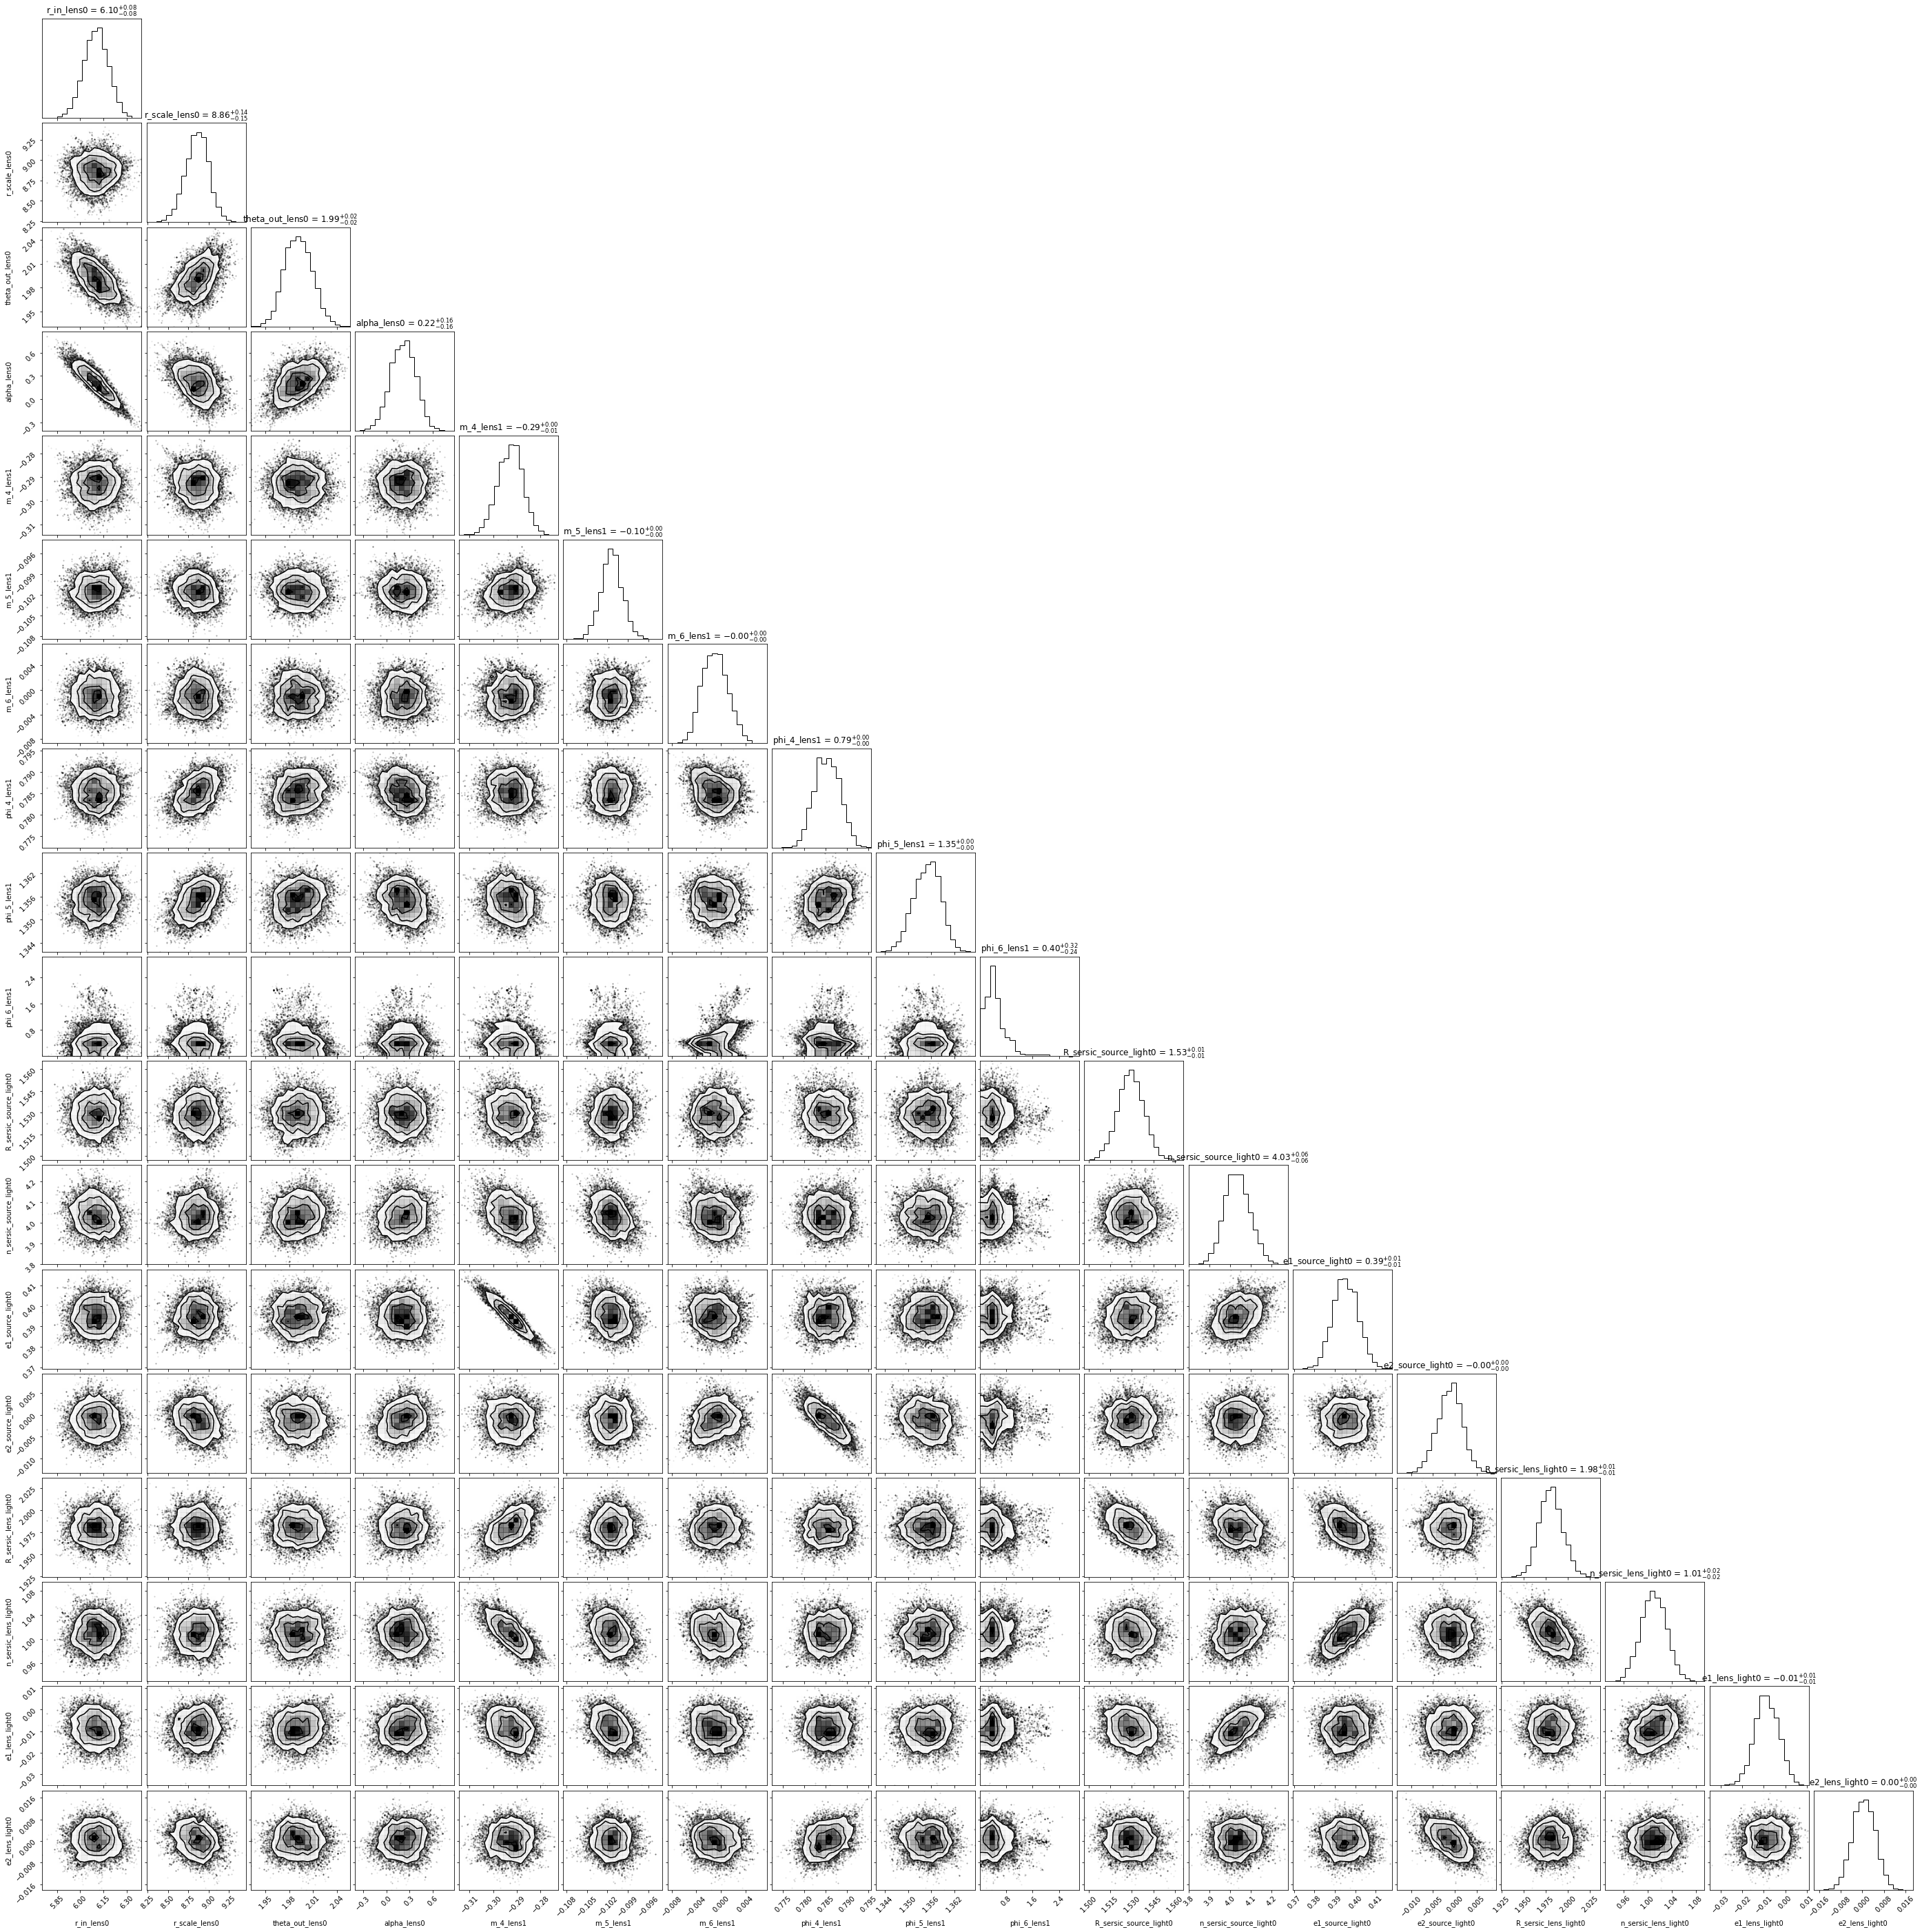

In [62]:
# the results of the MCMC chain

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[2]

for i in [1, 2]:
    chain_plot.plot_chain_list(chain_list, i)


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:], labels=param_mcmc[:], show_titles=True)


## Fitting a edge-on disk
The edge-on disk have a good model with some physics motivation. By adding such a light profile, we can generate the edge-on disk and perform fitting.

In [4]:
# No lense
lens_model_list = []
kwargs_lens = []

from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list, galaxy_morph = True)

# No source, i.e., no backkground
source_model_list = []
kwargs_source = []


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)

# Edge-on disk
kwargs_egde_disks = {'amp': 5, 'r_s': 1, 'h_s': 0.4, 'PA':3, 'center_x': 2, 'center_y': 0}
lens_light_model_list = ['EDGEONDISK']

kwargs_lens_light = [kwargs_egde_disks]
lens_light_model_class = LightModel(lens_light_model_list)

In [5]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

<ipython-input-6-fdef34d73218>:15: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


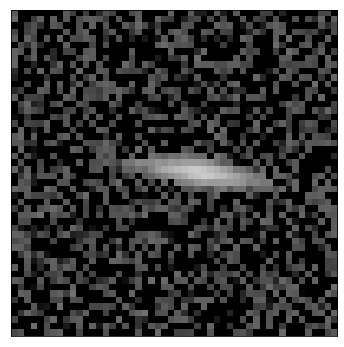

In [6]:
# display the initial simulated image
# Not that "real"

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [7]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []#kwargs_source
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


fixed_lens_light = []
kwargs_lens_light_init = []#kwargs_lens_light
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({})
kwargs_lens_light_init.append({'amp': 1, 'r_s': 3, 'h_s': 3, 'PA':1, 'center_x': 0, 'center_y': 0})
kwargs_lens_light_sigma.append({'amp': 1, 'r_s': 1, 'h_s': 1, 'PA':0, 'center_x': 2, 'center_y': 2})
kwargs_lower_lens_light.append({'amp': 0, 'r_s': 0, 'h_s': 0, 'PA':0, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'amp': 100, 'r_s': 10, 'h_s': 10, 'PA':np.pi, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,}

# Summary of init & real condition
print('kwargs_lens_light_init\n',kwargs_lens_light_init,)
print('kwargs_lens_light\n',kwargs_lens_light,)
print('kwargs_source_init\n',kwargs_source_init,)
print('kwargs_source\n',kwargs_source)
print('kwargs_lens_init\n',kwargs_lens_init)
print('kwargs_lens\n',kwargs_lens)

kwargs_lens_light_init
 [{'amp': 1, 'r_s': 3, 'h_s': 3, 'PA': 1, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light
 [{'amp': 5, 'r_s': 1, 'h_s': 0.4, 'PA': 3, 'center_x': 2, 'center_y': 0}]
kwargs_source_init
 []
kwargs_source
 []
kwargs_lens_init
 []
kwargs_lens
 []


In [12]:
# Start fitting
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list, 'galaxy_morph': True}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [ ['SIMPLEX', {'n_iterations': 100, }],
                        ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

{'lens_model_list': [], 'source_light_model_list': [], 'lens_light_model_list': ['EDGEONDISK'], 'galaxy_morph': True}
Performing the optimization using algorithm: Nelder-Mead
15.225579431631962 reduced X^2 of best position
-18986.297551245058 logL
2494.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'r_s': 0.29086991198633527, 'h_s': 2.823491623985219, 'PA': 1.5030394206283435, 'center_x': -0.0008555712276346742, 'center_y': -0.0010168563093423976}] lens light result
[] point source result
{} special param result
0.29875922203063965 time used for  SIMPLEX
{'lens_model_list': [], 'source_light_model_list': [], 'lens_light_model_list': ['EDGEONDISK'], 'galaxy_morph': True}
Computing the PSO ...
10
20
30
40
50
60
70
80
90
Converged after 90 iterations!
Best fit found:  -1505.612091247303 [0.22663708598370128, 1.7632059883789197, 1.5030394206283435, 1.9776188013053992, 0.00581642488317878]
-1.207387402764477 reduced X^2 of best position
-1505.612091247303 logL

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:03<00:00, 12.57it/s]

Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  200
Sampling iterations (in current run): 800
63.737528562545776 time taken for MCMC sampling


-1.2045082455647707 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.2045082455647709


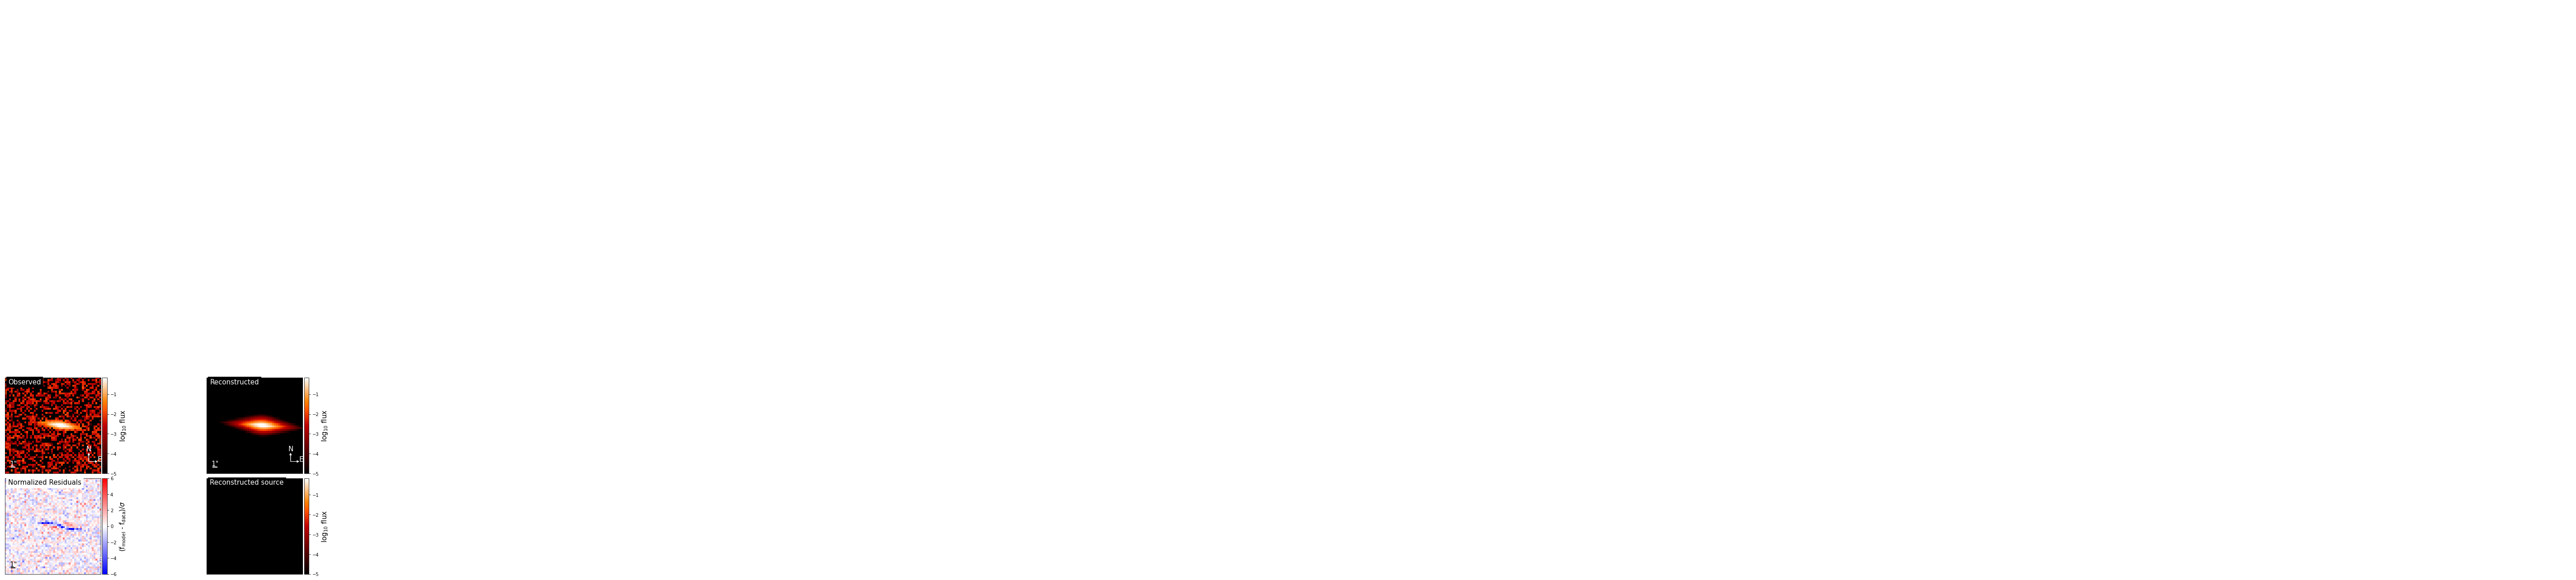

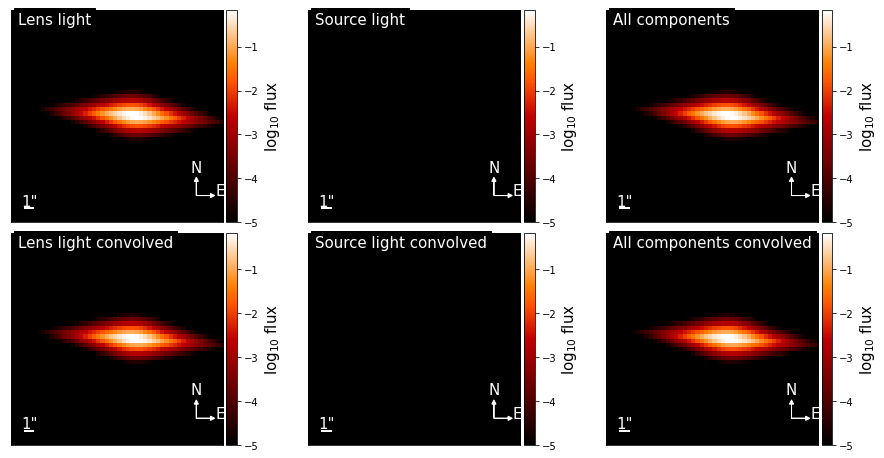

{'kwargs_lens': [], 'kwargs_source': [], 'kwargs_lens_light': [{'amp': 4.711534698131842, 'r_s': 0.2261536476667312, 'h_s': 1.7608508255711577, 'PA': 1.5030394206283435, 'center_x': 1.9773638686350623, 'center_y': 0.0054201434790401995}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [13]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[1,0], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 1], deltaPix_source=0.01, numPix=100)

f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

## Mulitple non-axisymmetric components

In parts above we have go through some examples with a simple components as the sprial arms. Taking the advantage of the lenstronomy's architecture, the operations are straight-forward. However, when it comes to real galaxies, we commonly need more than one compoents for the spiral arms. 

In [89]:
# Put the lens into complexspiral 
lens_model_list = []
kwargs_lens = []

from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list, galaxy_morph = True)

# No source, i.e., no background light
source_model_list = []
kwargs_source = []


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list, galaxy_morph = True)

# Sprial
kwargs_CS1 = {'amp': 1, 'R_sersic': 3, 'n_sersic': 1, 'e1': 0.4, 'e2': 0, 'theta_PA':1, 'q':2, 'center_x': 0, 'center_y': 0,  # source param
                 'r_in_0': 3, 'r_scale_0': 5, 'theta_out_0':3, 'alpha_0': 1,  # PHT param
                 'Strength_1': 0.03, 'phi_1': 1} # Bending3 param
kwargs_CS2 = {'amp': 0.1, 'R_sersic': 5, 'n_sersic': 1, 'e1': 0.4, 'e2': 0, 'theta_PA':1, 'q':2, 'center_x': 3, 'center_y': 0,  # source param
              'r_in_0': 6, 'r_scale_0': 9, 'theta_out_0': 2, 'alpha_0': 0.3,  # PHT param
              'm_1_1': 0, 'm_3_1': 0, 'm_4_1': 0.1, 'm_5_1': 0.3, 'm_6_1': 0,   # fourier param
              'phi_1_1': 0, 'phi_3_1': 0, 'phi_4_1': 2, 'phi_5_1': 1, 'phi_6_1': 1}
morph_model_list = [['PHT', 'Bending3'], ['PHT', 'Fourier']]
lens_light_model_list = ['COMPLEXSPRIAL', 'COMPLEXSPRIAL']

kwargs_lens_light = [kwargs_CS1, kwargs_CS2]
lens_light_model_class = LightModel(lens_light_model_list, galaxy_morph = True, morph_model_list = morph_model_list)

Example of parameter list:
 {'amp': 0, 'R_sersic': 0, 'n_sersic': 0, 'e1': 0, 'e2': 0, 'theta_PA': 0, 'q': 0, 'center_x': 0, 'center_y': 0, 'r_in_0': 0, 'r_scale_0': 0, 'theta_out_0': 0, 'alpha_0': 0, 'Strength_1': 0, 'phi_1': 0}
Example of parameter list:
 {'amp': 0, 'R_sersic': 0, 'n_sersic': 0, 'e1': 0, 'e2': 0, 'theta_PA': 0, 'q': 0, 'center_x': 0, 'center_y': 0, 'r_in_0': 0, 'r_scale_0': 0, 'theta_out_0': 0, 'alpha_0': 0, 'm_1_1': 0, 'm_3_1': 0, 'm_4_1': 0, 'm_5_1': 0, 'm_6_1': 0, 'phi_1_1': 0, 'phi_3_1': 0, 'phi_4_1': 0, 'phi_5_1': 0, 'phi_6_1': 0}


In [90]:
# import main simulation class of lenstronomy
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numPix, numPix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

# if you are using a PSF estimate from e.g. a star in the FoV of your exposure, you can set
#kwargs_psf = {'psf_type': 'PIXEL', 'pixel_size': deltaPix, 'kernel_point_source': 'odd numbered 2d grid with centered star/PSF model'}


psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)

poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

<ipython-input-91-fdef34d73218>:15: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])


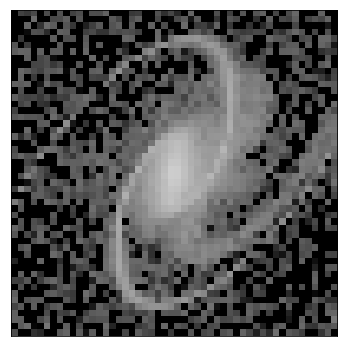

In [91]:
# display the initial simulated image
# Not that "real"

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

We don't bother to fitting this complex shape here, --- one should be confident about the performance of fitting procedure with SIMPLEX (as GALFIT just did so). Now we will try to show the pattern of distortion instead.

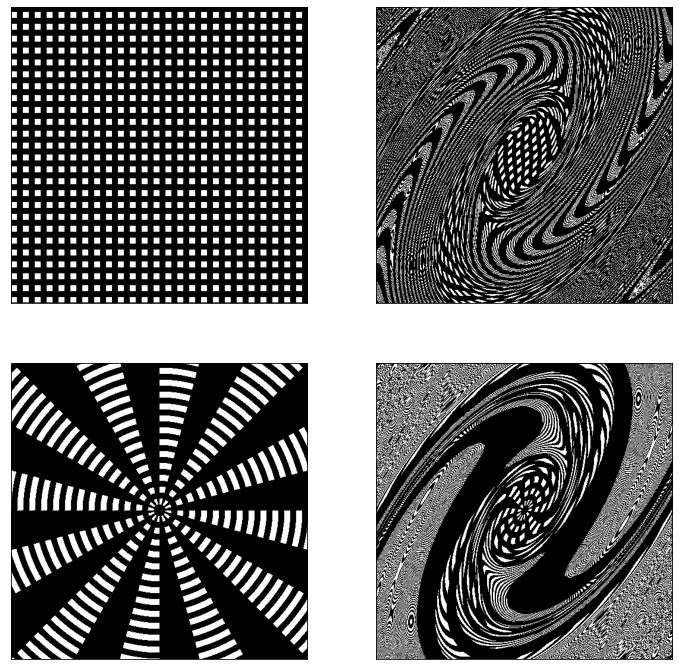

In [88]:
# The distortion of first model
image_image, image_source = imageModel.LensLightModel.func_list[0].mapping_image_to_source(coord = 'cart', **kwargs_CS1)

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes[0][0]
ax.imshow(image_image, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax = axes[0][1]
ax.imshow(image_source, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
image_image, image_source = imageModel.LensLightModel.func_list[0].mapping_image_to_source(coord = 'polar', **kwargs_CS1)
ax = axes[1][0]
ax.imshow(image_image, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax = axes[1][1]
ax.imshow(image_source, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

In [12]:
# The distortion of second model but reversely
image_image, image_source = imageModel.LensLightModel.func_list[1].mapping_source_to_image(coord = 'cart', **kwargs_CS2)
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False, sharey=False)
ax = axes[0][0]
ax.imshow(image_image, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax = axes[0][1]
ax.imshow(image_source, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
image_image, image_source = imageModel.LensLightModel.func_list[1].mapping_source_to_image(coord = 'polar', **kwargs_CS2)
ax = axes[1][0]
ax.imshow(image_image, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax = axes[1][1]
ax.imshow(image_source, origin='lower', cmap=cmap)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002498070D760>,
      dtype=object)